# Neural Collaborative Filtering

### Dataset

The dataset used for this project is from "https://grouplens.org/datasets/movielens/1m/". You need to download and extract the dataset. In this case, we will be using 'ratings.dat' file from the download.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300

import warnings 
warnings.filterwarnings('ignore')

In [2]:
"""
Read and process data
"""

data_df = pd.read_csv('ratings.dat', sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# Setting a fixed seed for comparing results
np.random.seed(0)

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# Generate train_df with 70% samples and test_df with 30% samples, 
# and there should have no overlap between them.
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

train_df.head(10)

,UserID,MovieID,Rating,Timestamp,movieID
0,0,0,5,978300760,0
2,0,2,3,978301968,2
3,0,3,4,978300275,3
4,0,4,5,978824291,4
5,0,5,3,978302268,5
6,0,6,5,978302039,6
9,0,9,4,978301368,9
11,0,11,4,978301752,11
12,0,12,4,978302281,12
14,0,14,5,978301753,14


In [3]:
# Set Training parameters
BATCH_SIZE = 1024
LATENT_DIM = 10
DROPOUT = 0.2
LR = 0.0005

num_users = len(data_df.UserID.unique())
num_movies = len(data_df.movieID.unique())


In [4]:
# Prepare dataset for training
class MovieLensDataset(Dataset):
    def __init__(self, user_ids, movie_ids, ratings):
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.ratings = ratings
        
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        movie_id = self.movie_ids[idx]
        rating = self.ratings[idx]
        return torch.tensor(user_id), torch.tensor(movie_id), torch.tensor(rating)

# Define the dataset and dataloader
train_dataset = MovieLensDataset(train_df.UserID.values, train_df.MovieID.values, train_df.Rating.values)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MovieLensDataset(test_df.UserID.values, test_df.MovieID.values, test_df.Rating.values)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, latent_dim=10, dropout=0.2):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users + 1, latent_dim, padding_idx=0)
        self.movie_embedding = nn.Embedding(num_movies + 1, latent_dim, padding_idx=0)
        self.fc1 = nn.Linear(latent_dim*2, 100)
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(100, 100)
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc4 = nn.Linear(50, 1)

    def forward(self, user_input, movie_input):
        user_vec = self.user_embedding(user_input)
        user_vec = user_vec.view(-1, user_vec.size(1))
        movie_vec = self.movie_embedding(movie_input)
        movie_vec = movie_vec.view(-1, movie_vec.size(1))
              
        concat = torch.cat([user_vec, movie_vec], dim=1)
        concat_dropout = self.dropout1(concat)
        
        fc1 = nn.functional.relu(self.fc1(concat_dropout))
        fc1_dropout = self.dropout1(fc1)
        
        fc2 = nn.functional.relu(self.fc2(fc1_dropout))
        fc2_dropout = self.dropout2(fc2)
        
        fc3 = nn.functional.relu(self.fc3(fc2_dropout))
        fc3_dropout = self.dropout3(fc3)
        
        output = self.fc4(fc3_dropout)
        
        return output

# Instantiate the model
model = RecommenderNet(num_users, num_movies, latent_dim=LATENT_DIM, dropout=DROPOUT)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [6]:
# Testing
def test(test_loader, model, optimizer):
    with torch.no_grad():
        test_loss = []
        for batch_idx, (user_input, movie_input, rating) in enumerate(test_loader):

            # Forward pass
            output = model(user_input, movie_input)

            # Compute loss
            loss = criterion(output.squeeze().float(), rating.float())
            test_loss.append(loss.item() / BATCH_SIZE)

    return np.array(test_loss).mean()

Now is the training part. We will print out the test loss and training loss for each epoch and will stop training when the model starts to overfit i.e. at a point where test loss is not decreasing or very slowly decreasing but training loss is steadily decreasing.

In [7]:
# Training
num_epochs = 25
train_losses = []
for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (user_input, movie_input, rating) in enumerate(train_loader):
        
        # Forward pass
        output = model(user_input, movie_input)

        # Compute loss
        loss = criterion(output.squeeze().float(), rating.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item() / BATCH_SIZE)
        epoch_loss.append(loss.item() / BATCH_SIZE)
        
    test_loss = test(test_loader, model, optimizer)
    print('Epoch [{}/{}], Train Loss: {:.8f}, Test Loss: {:.8f}'.
          format(epoch+1, num_epochs, np.array(epoch_loss).mean(), test_loss))
          

Epoch [1/25], Train Loss: 0.00198081, Test Loss: 0.00138355
Epoch [2/25], Train Loss: 0.00134339, Test Loss: 0.00131951
Epoch [3/25], Train Loss: 0.00129720, Test Loss: 0.00128067
Epoch [4/25], Train Loss: 0.00125139, Test Loss: 0.00123667
Epoch [5/25], Train Loss: 0.00120106, Test Loss: 0.00118137
Epoch [6/25], Train Loss: 0.00115682, Test Loss: 0.00114229
Epoch [7/25], Train Loss: 0.00111843, Test Loss: 0.00110712
Epoch [8/25], Train Loss: 0.00108442, Test Loss: 0.00107577
Epoch [9/25], Train Loss: 0.00105585, Test Loss: 0.00104899
Epoch [10/25], Train Loss: 0.00102659, Test Loss: 0.00102518
Epoch [11/25], Train Loss: 0.00100232, Test Loss: 0.00099950
Epoch [12/25], Train Loss: 0.00098004, Test Loss: 0.00098385
Epoch [13/25], Train Loss: 0.00096312, Test Loss: 0.00096785
Epoch [14/25], Train Loss: 0.00094849, Test Loss: 0.00095565
Epoch [15/25], Train Loss: 0.00093484, Test Loss: 0.00094361
Epoch [16/25], Train Loss: 0.00092489, Test Loss: 0.00093448
Epoch [17/25], Train Loss: 0.0009

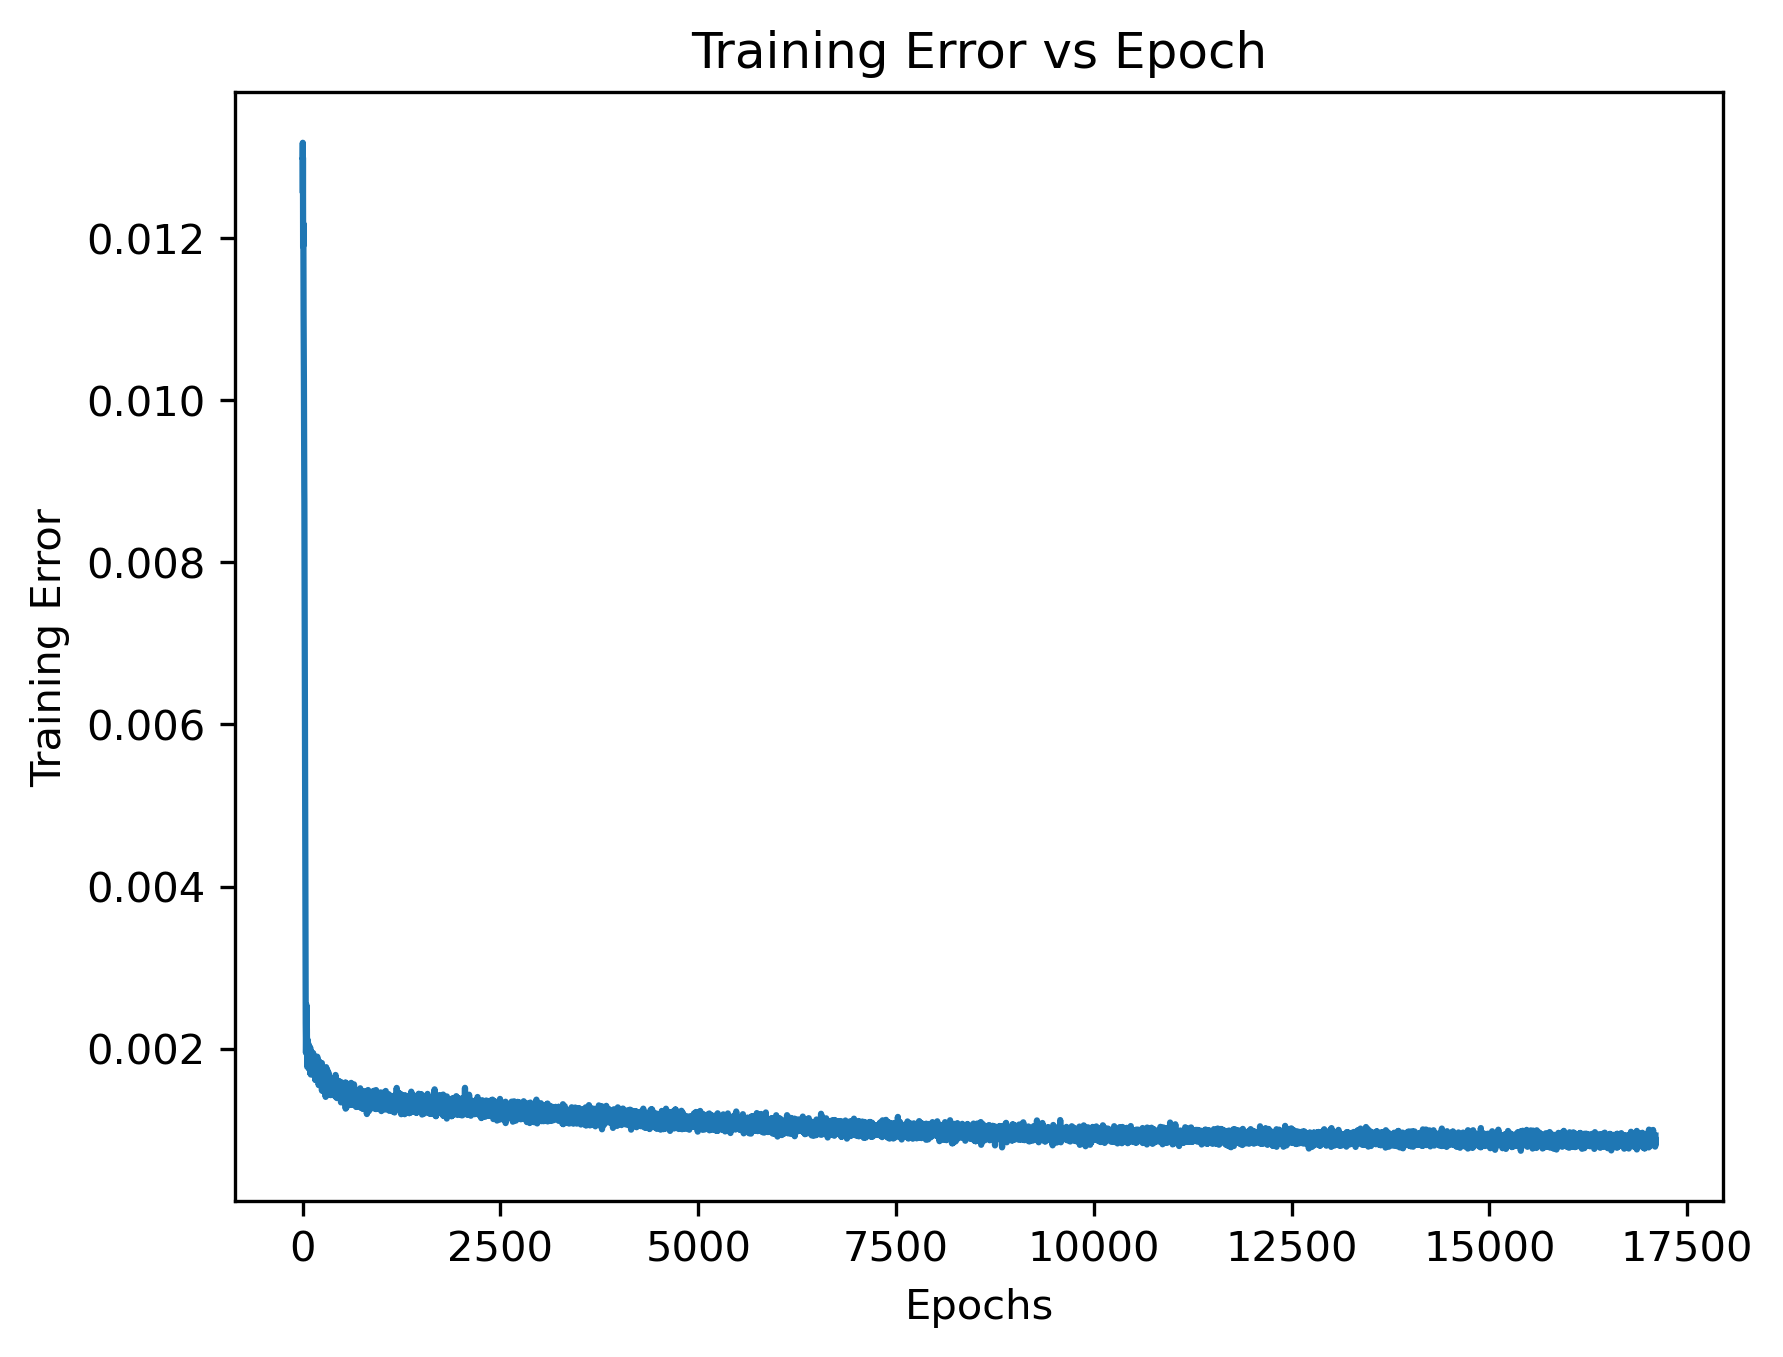

In [10]:
# Plot the training progress
sns.lineplot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
ign_text = plt.title('Training Error vs Epoch')
plt.show()

Check out a few predictions

In [11]:
sample_test_indices = np.random.random(len(test_df))<0.0001 
sample_test_data = test_df[sample_test_indices]
sample_test_data.drop(['Timestamp','movieID'], axis = 1, inplace = True)

y_hat = np.round(model(torch.tensor(sample_test_data.UserID.values), torch.tensor(sample_test_data.MovieID.values)).detach().numpy(), decimals=2)
y_true = sample_test_data.Rating
sample_test_data['Predicted_Rating'] = y_hat
sample_test_data['Absolute_error'] = [np.abs(i) for i in sample_test_data['Predicted_Rating'] - sample_test_data['Rating']]
sample_test_data

,UserID,MovieID,Rating,Predicted_Rating,Absolute_error
3360,24,322,4,3.87,0.13
64811,434,99,5,4.19,0.81
76973,522,1835,3,3.63,0.63
120822,777,264,3,3.88,0.88
129717,838,1981,4,4.13,0.13
164450,1050,2607,2,2.40,0.40
190764,1180,513,2,2.48,0.48
220617,1336,3223,3,3.83,0.83
350002,2053,259,5,4.71,0.29
430621,2623,531,5,3.63,1.37
